          [,1]      [,2]         [,3]
[1,] 0.4773078 0.5004829 2.220936e-02
[2,] 0.2473314 0.5984605 1.542081e-01
[3,] 0.4159325 0.5840675 1.712192e-44
         [,1]       [,2]
[1,] 1.071619 118.772562
[2,] 1.156710   5.509950
[3,] 4.749398   4.287957


[1]  1.000000e+00 5.284195e-247  0.000000e+00

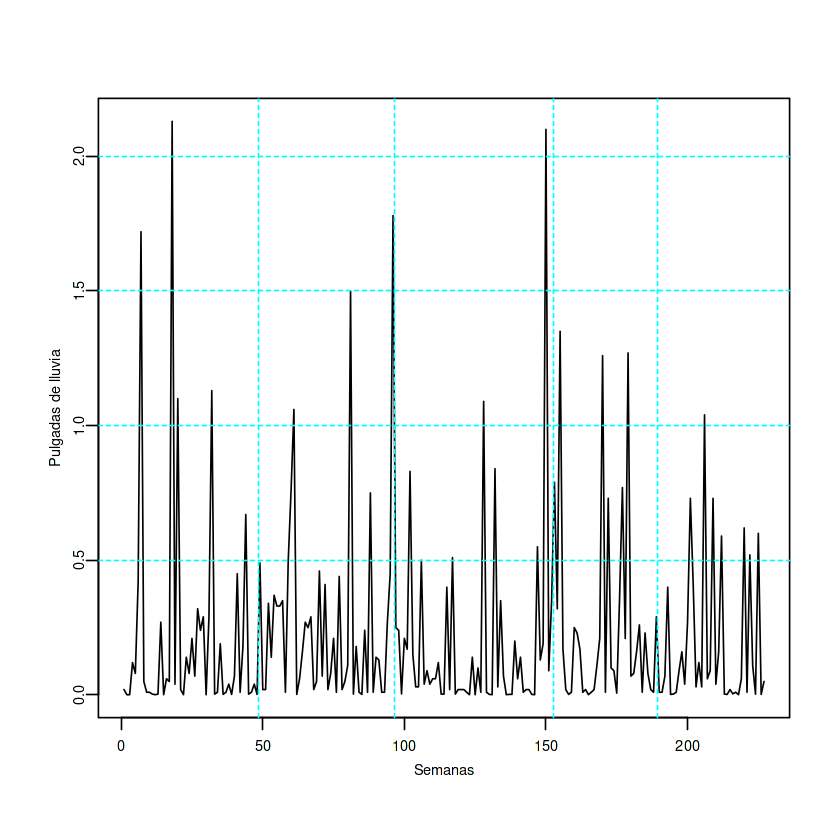

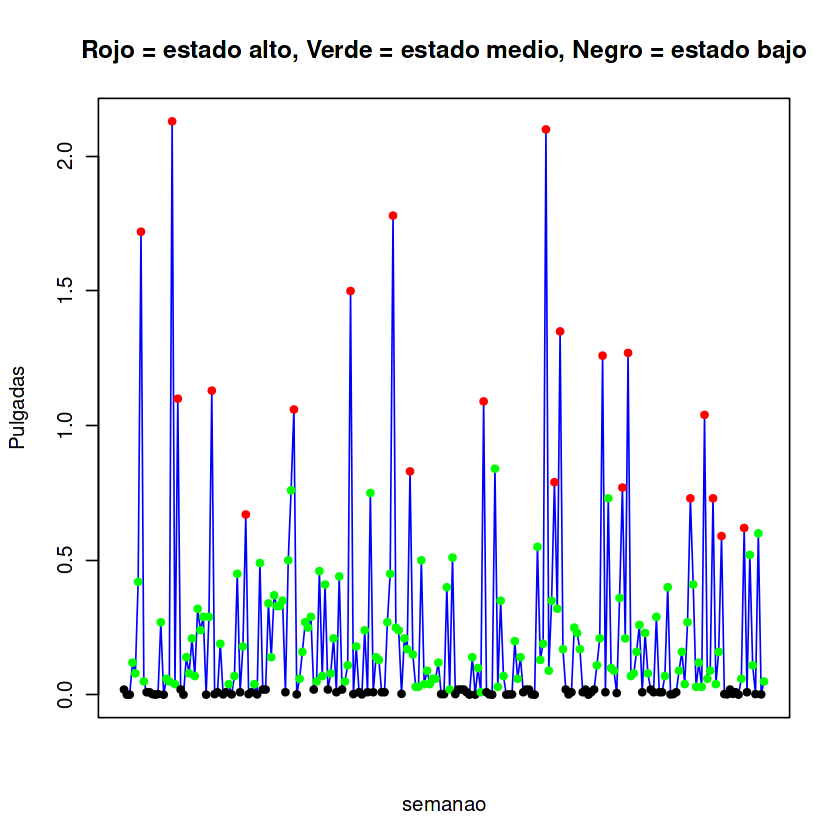

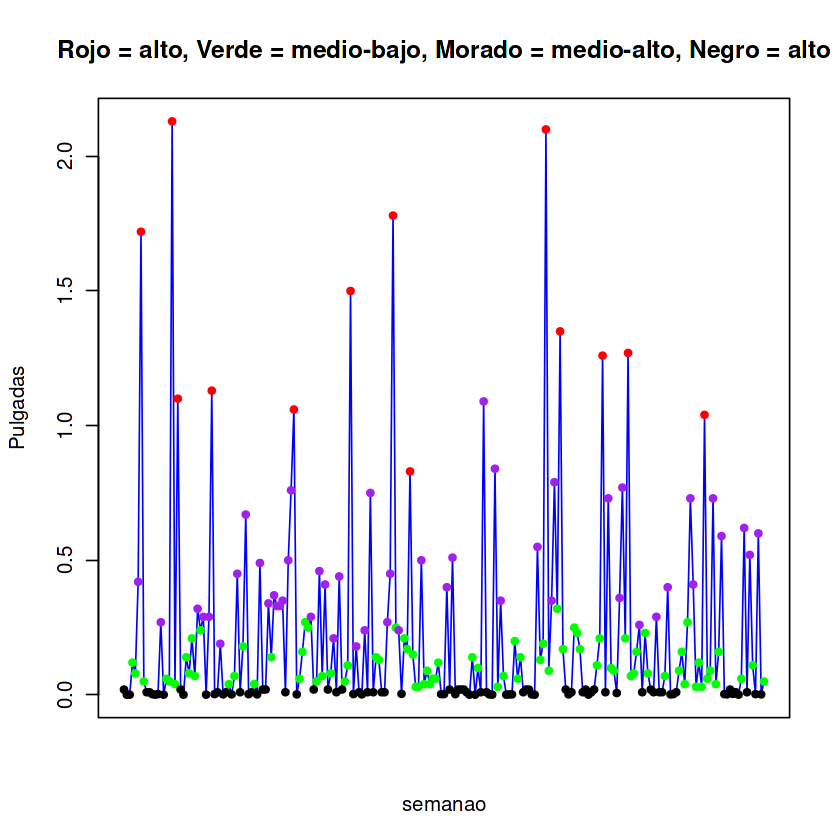

In [3]:
library("fitdistrplus")


# Lectura de los datos
datos <- read.csv( "/kaggle/input/lluvias/lluvia.csv", header=FALSE)
dat <- as.vector(na.omit(as.vector(as.matrix(datos))))
aa <- list(P1960=datos[,1],P1961=datos[,2],P1962=datos[,3],
           P1963=datos[,4],P1964=datos[,5],Todos=dat)

# Presentación de los datos
#par(mfrow=c(2,1),mar=c(3, 3, 2, 2))
#boxplot(aa,horizontal=TRUE,xlab="Precipitaci ́on (pulg)",border="blue",
#        col="cyan",cex.axis=.7,cex.lab=.7, mgp=c(1.5,.5,0))
plot(dat,type="l",
     cex.axis=.7,cex.lab=.7, mgp=c(1.5,.5,0),
     xlab="Semanas",ylab="Pulgadas de lluvia")
abline(v=c(48,96,152,189)+0.5,h=c(.5,1.0,1.5,2.0),lty=2,col="cyan")


# Algoritmo EM para HMM con K=3 estados para la cadena latente
# y emisiones Gamma para cada estado.
# Inicializacíon de pa ́ametros
yy = dat
n = length(yy)
K = 3
del = c(length(which(yy<.5))/n,length(intersect(which(yy>.5),which(yy<1)))/n,
        length(which(yy>1))/n)
Gam = matrix(c(.2,.6,.2,.3,.3,.3,.2,.75,.05),ncol=K,byrow=T)
params_bajo = fitdist(yy[which(yy<.5)],distr="gamma")$estimate
params_medio = fitdist(yy[intersect(which(yy>.5),which(yy<1))],
                       distr = "gamma")$estimate
params_alto = fitdist(yy[which(yy>1)],distr="gamma")$estimate
params<-matrix(c(params_bajo,params_medio,params_alto),3,2,byrow = TRUE)
# Empieza ćodigo ge ́erico, funciona para diferentes K’s
gams = matrix(0,n,K)
alf = matrix(0,n,K)
bet = matrix(0,n,K)
vs = array(0,dim=c(K,K,n-1))
# Algoritmo EM para HMMs
M = 100
L = rep(0,M)


#Función a maximizar para encontrar los parámetros estimados
g<-function(parametos,suma_us,suma_us_yy,suma_us_logyy){
  alfa<- parametos[1]
  lambda <- parametos[2]
  return( -( (alfa*log(lambda) -log(gamma(alfa)))*suma_us +
          (alfa-1)*suma_us_logyy -lambda*suma_us_yy ) )
}
  


# Empiezan M iteraciones del EM
for(k in 1:M){
  # Ćalculo de las K distribuciones Gamma, evaluadas en los n datos
  for(j in 1:K){ gams[,j] = dgamma(yy,shape = params[j,1],rate = params[j,2]) }
  # Ćalculo de alfas
  alf[1,] = del*gams[1,]
  for(i in 2:n){ alf[i,] = colSums(alf[i-1,]*(t(gams[i,]*t(Gam)))) }
  # C ́alculo de betas
  bet[n,] = rep(1,K)
  for(i in (n-1):1){ bet[i,] = t(gams[i+1,]*t(Gam))%*%bet[i+1,] }
  # C ́alculo de us
  us = alf*bet
  # C ́alculo de vs
  for(i in 1:(n-1)){vs[,,i]=outer( alf[i,],bet[i+1,]*gams[i+1,] )*Gam}
  # Estimaci ́on de nuevos par ́ametros en el paso M
  del = us[1,]/sum(us[1,])
  aa = matrix(0,K,K)
  for(i in 1:(n-1)){ aa = aa+vs[,,i] }
  Gam = aa/rowSums(aa)
  for(i in 1:K){ params[i,] = optim(g,par=c(2,4),suma_us = sum(us[,i]),
                                    suma_us_yy = sum(us[,i]*yy),
                                    suma_us_logyy = sum(us[,i]*log(yy)))$par }
  L[k] = sum(alf[n,]) }
# Terminan M iteraciones del EM


# Resultados:
print(Gam)
# Matriz de transición
print(params)
# Parámetro para las distribuciones. De arriba a abajo: bajo, medio, alto.
del
# Distribución inicial


#Predicciones
predestado = apply((alf*bet)/L[M],1,which.max)
plot(1:n,dat,type="l",lwd=1,col="blue",xlab="semanao",
     ylab="Pulgadas",xaxt="n",
     main="Rojo = estado alto, Verde = estado medio, Negro = estado bajo")
cc = c("black","green","red",
       cex.axis=.7,cex.lab=.7, mgp=c(1.5,.5,0))
cce = cc[predestado]
points(1:n,dat,pch=20,col=cce)

















# Si corremos el algoritmo EM con esta inicializacion, tendremos 
# 4 estados de la variable latente.
yy = dat
n = length(yy)
K = 4
del = c(length(which(yy<.1))/n,length(intersect(which(yy>.1),which(yy<.5)))/n,
        length(intersect(which(yy>.5),which(yy<1)))/n,
        length(which(yy>1))/n)
Gam = matrix(c(.3,.3,.3,.1,.3,.3,.3,.1,.2,.35,.35,.1,.1,.2,.65,.05),ncol=K,byrow=T)
params_bajo = fitdist(yy[which(yy<.1)],distr="gamma")$estimate
params_bajo_medio = fitdist(yy[intersect(which(yy>.1),which(yy<.5))],distr="gamma")$estimate
params_medio = fitdist(yy[intersect(which(yy>.5),which(yy<1))],
                       distr = "gamma")$estimate
params_alto = fitdist(yy[which(yy>1)],distr="gamma")$estimate
params_inicial<-matrix(c(params_bajo,params_bajo_medio,params_medio,params_alto),4,2,byrow = TRUE)
params<-params_inicial
# Empieza ćodigo gen ́erico, funciona para diferentes K’s
gams = matrix(0,n,K)
alf = matrix(0,n,K)
bet = matrix(0,n,K)
vs = array(0,dim=c(K,K,n-1))
# Algoritmo EM para HMMs
M = 100
L = rep(0,M)

# Empiezan M iteraciones del EM
for(k in 1:M){
  # Ćalculo de las K distribuciones Gamma, evaluadas en los n datos
  for(j in 1:K){ gams[,j] = dgamma(yy,shape = params[j,1],rate = params[j,2]) }
  # Ćalculo de alfas
  alf[1,] = del*gams[1,]
  for(i in 2:n){ alf[i,] = colSums(alf[i-1,]*(t(gams[i,]*t(Gam)))) }
  # C ́alculo de betas
  bet[n,] = rep(1,K)
  for(i in (n-1):1){ bet[i,] = t(gams[i+1,]*t(Gam))%*%bet[i+1,] }
  # C ́alculo de us
  us = alf*bet
  # C ́alculo de vs
  for(i in 1:(n-1)){vs[,,i]=outer( alf[i,],bet[i+1,]*gams[i+1,] )*Gam}
  # Estimaci ́on de nuevos par ́ametros en el paso M
  del = us[1,]/sum(us[1,])
  aa = matrix(0,K,K)
  for(i in 1:(n-1)){ aa = aa+vs[,,i] }
  Gam = aa/rowSums(aa)
  for(i in 1:K){ params[i,] = optim(g,par=c(2,4),suma_us = sum(us[,i]),
                                    suma_us_yy = sum(us[,i]*yy),
                                    suma_us_logyy = sum(us[,i]*log(yy)))$par }
  L[k] = sum(alf[n,]) }
# Terminan M iteraciones del EM





# Predicciones.
predestado = apply((alf*bet)/L[M],1,which.max)
plot(1:n,dat,type="l",lwd=1,col="blue",xlab="semanao",
     ylab="Pulgadas",xaxt="n",
     main="Rojo = alto, Verde = medio-bajo, Morado = medio-alto, Negro = alto")
cc = c("black","green","purple","red")
cce = cc[predestado]
points(1:n,dat,pch=20,col=cce)